In [1]:
import pandas as pd
from cryptography.hazmat.backends.openssl import backend
from dask.bag.core import to_dataframe
from dask.dataframe import DataFrame
from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
adata = pd.read_csv('/Users/gengzhi/Desktop/all_data.csv')
adata = adata[adata['surgical_classify']!=1]
index= range(0,adata.shape[0])
adata.index = index

In [2]:
impute = KNNImputer(n_neighbors=2)
adata['CRP'] = impute.fit_transform(adata)[:,69]

In [3]:
# perform log transformation on some columns,including NEUT,SII,EO,BASO,TT,FDP,D_D,AST,ALT,AST_ALT,GGT_Y,CK,TG,HCY,HbA1c,CRP,GLU
X = adata.copy()
X['NEUT_log10'] = np.log10(X['NEUT'])
X['SII_log10'] = np.log10(X['SII'])
X['BASO_log10'] = np.log10(X['BASO']+0.005)
X['TT_log10'] = np.log10(X['TT'])
X['FDP_log10'] = np.log10(X['FDP'])
X['D_D_log10'] = np.log10(X['D_D'])
X['AST_log10'] = np.log10(X['AST'])
X['ALT_log10'] = np.log10(X['ALT'])
X['AST_ALT_log10'] = np.log10(X['AST_ALT'])
X['GGT_Y_log10'] = np.log10(X['GGT_Y'])
X['CK_log10'] = np.log10(X['CK'])
X['TG_log10'] = np.log10(X['TG'])
X['HCY_log10'] = np.log10(X['HCY'])
X['HbA1c_log10'] = np.log10(X['HbA1c'])
X['GLU_log10'] = np.log10(X['GLU'])
for i in ['NEUT', 'SII', 'BASO', 'TT', 'FDP', 'D_D', 'AST', 'ALT', 'AST_ALT', 'GGT_Y', 'CK', 'TG', 'HCY', 'HbA1c', 'GLU']:
    X.drop(i, axis=1, inplace=True)
adata = X

In [4]:
def return_same(a,b):
    set1 = []
    for i in range(0,len(a)):
          if a.iloc[i] == b.iloc[i] == True:
             set1.append(1)
          else:
             set1.append(0)
    return to_dataframe(set1,columns=['judge'],dtypes='int64')
def get_index(a):
    index = []
    for i in range(0,len(a)):
        if a.iloc[i] == 1:
            index.append(i)
    return index

In [5]:
auc = {}
deleted =[]
positive_percentage = []
model_params = {}
for i in range(3,1862):
    auc[i] = {}
    model_params[i] = {}
for i in range(3,1862):
    data = adata.copy()
    data['test'] = data['survival_time'] < i
    data['judge']= return_same(data['survival_time'] < i,data['death'] == 0)
    data["SSUM"+str(i)] = data['judge'] + data['test']
    data=data.drop(['test','judge','survival_time','death'],axis=1)
    deleted.append(len(get_index(data['SSUM'+str(i)]==2)))
    data=data.drop(get_index(data['SSUM'+str(i)]==2),axis = 0)
    positive_percentage.append(sum(data['SSUM'+str(i)])/len(data['SSUM'+str(i)]))
    for j in range(0,100):
        X = data.drop(['SSUM'+str(i)],axis=1)
        y = data['SSUM'+str(i)]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=j,stratify=y)
        scaler = StandardScaler()
        features = X.columns
        X_train = pd.DataFrame(X_train, columns=features)
        X_train.reindex(range(0,len(X_train)),copy=True)
        X_train1 = scaler.fit_transform(X_train.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete'], axis=1))
        X_train1 = pd.DataFrame(X_train1, columns=features.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']))
        X_train['EO'] = X_train['EO'] / 0.1748658452351037 
        X_train['CRP'] = X_train['CRP'] / 19.26822991505532
        X_train1['EO'] = X_train['EO'].values
        X_train1['CRP'] = X_train['CRP'].values
        X_train1[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']] = X_train[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']].values
        X_train = X_train1
        X_test = pd.DataFrame(X_test, columns=features)
        X_test.reindex(range(0,len(X_test)),copy=True)
        X_test1 = scaler.transform(X_test.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete'], axis=1))
        X_test1 = pd.DataFrame(X_test1, columns=features.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']))
        X_test['EO'] = X_test['EO'] / 0.1748658452351037
        X_test['CRP'] = X_test['CRP'] / 19.26822991505532
        X_test1['EO'] = X_test['EO'].values
        X_test1['CRP'] = X_test['CRP'].values
        X_test1[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']] = X_test[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']].values
        X_test = X_test1
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:,1]
        auc[i][j] = roc_auc_score(y_test, y_pred)
        model_params[i][j] = model.coef_
    

The optimal threshold is 400, with AUC =  0.8314265709784701


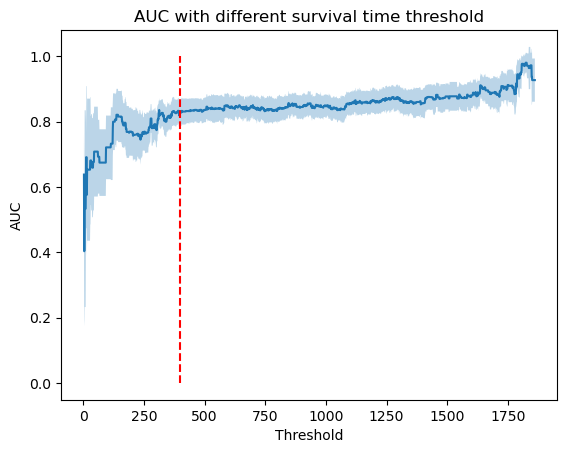

In [6]:
import matplotlib.pyplot as plt
import numpy as np
def dict_mean(d):
    return sum(d.values())/len(d)
def dict_std(d):
    mean = dict_mean(d)
    return np.sqrt(sum([(x - mean) ** 2 for x in d.values()]) / len(d))
mean_auc = []
for i in range(3,1862):
    mean_auc.append(dict_mean(auc[i]))
std_auc = []
for i in range(3,1862):
    std_auc.append(dict_std(auc[i]))
x = range(3,1862)
y = mean_auc
plt.plot(x, y)
plt.vlines(x=400,ymin=0,ymax=1,colors='r',linestyles='dashed')
plt.fill_between(x, np.array(y)-np.array(std_auc), np.array(y)+np.array(std_auc), alpha=0.3)
plt.title('AUC with different survival time threshold')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.savefig('/Users/gengzhi/Desktop/threshold_selection.pdf',backend='pgf')
print("The optimal threshold is 400, with AUC = ",mean_auc[397])

The optimal threshold is 400, with number of deleted samples =  22


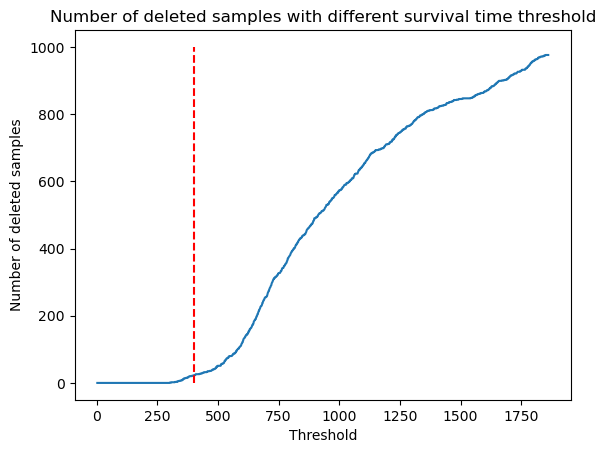

In [7]:
xa = range(3,1862)
ya = deleted
plt.plot(xa, ya)
plt.title('Number of deleted samples with different survival time threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of deleted samples')
plt.vlines(x=400,ymin=0,ymax=1000,colors='r',linestyles='dashed')
plt.savefig('/Users/gengzhi/Desktop/deleted.pdf',backend='pgf')
print("The optimal threshold is 400, with number of deleted samples = ",deleted[397])

The optimal threshold is 400, with positive percentage =  0.12688553682342502


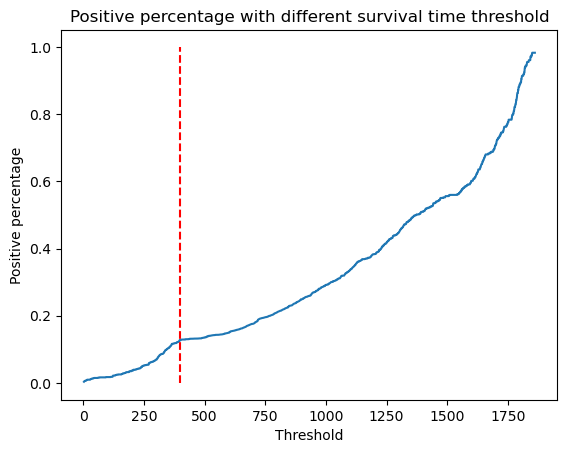

In [8]:
xb = range(3,1862)
yb = positive_percentage
plt.plot(xb, yb)
plt.title('Positive percentage with different survival time threshold')
plt.xlabel('Threshold')
plt.ylabel('Positive percentage')
plt.vlines(x=400,ymin=0,ymax=1,colors='r',linestyles='dashed')
plt.savefig('/Users/gengzhi/Desktop/positive_percentage.pdf',backend='pgf')
print("The optimal threshold is 400, with positive percentage = ",positive_percentage[397])

In [9]:
import numpy as np
params = {}
for ix in range(0,70):
    params[ix] = []
for i in range(400,1600):
    for j in range(0,100):
        for ix in range(0,70):
            params[ix].append(model_params[i][j][0][ix])

In [10]:
mean_params = []
for ix in range(0,70):
    mean_params.append(np.mean(params[ix]))
std_params = []
for ix in range(0,70):
    std_params.append(np.std(params[ix]))
    

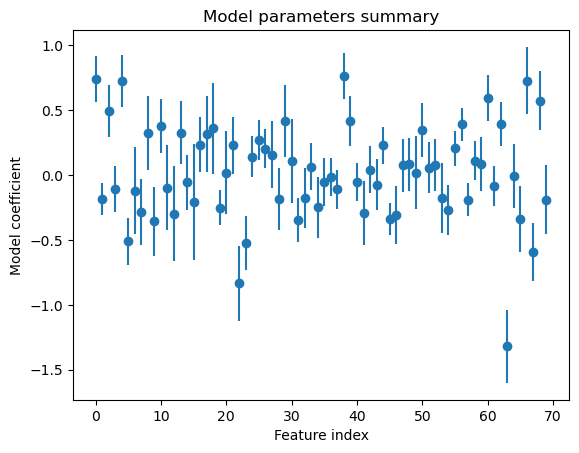

In [11]:
plt.errorbar(range(0,70),mean_params,std_params,fmt='o')
plt.title('Model parameters summary')
plt.xlabel('Feature index')
plt.ylabel('Model coefficient')
plt.savefig('/Users/gengzhi/Desktop/params.pdf',backend='pgf')

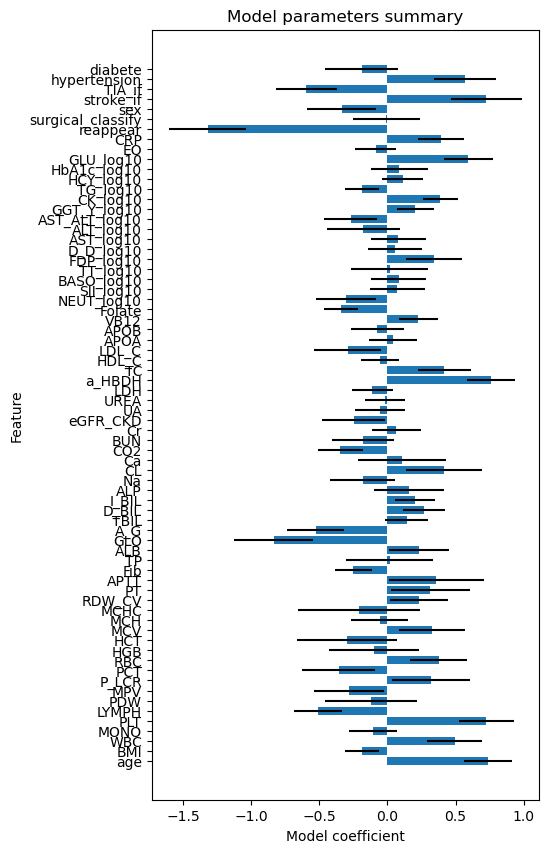

In [12]:
# pull the figure longer
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(range(0,70),mean_params,xerr=std_params)
ax.set_yticks(range(0,70))
ax.set_yticklabels(X_test.columns)
plt.title('Model parameters summary')
plt.xlabel('Model coefficient')
plt.ylabel('Feature')
plt.savefig('/Users/gengzhi/Desktop/params.pdf',backend='pgf')

In [13]:
params = pd.DataFrame(mean_params,columns=['mean'],index=X_test.columns)
params['std'] = std_params

In [14]:
params = params.sort_values(by='mean',ascending=True)

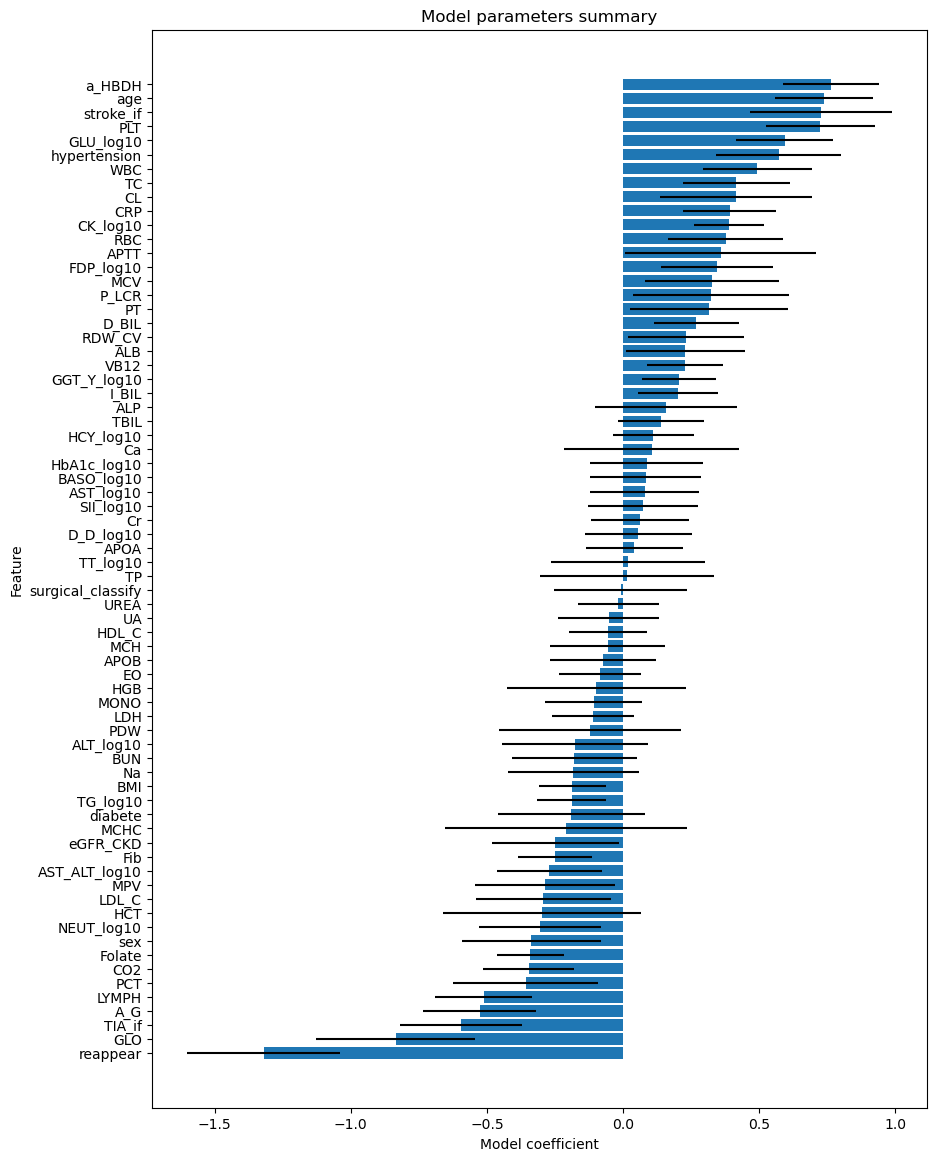

In [15]:
fig,ax = plt.subplots(figsize=(10,14))
ax.barh(range(0,70),params['mean'],xerr=params['std'])
ax.set_yticks(range(0,70))
ax.set_yticklabels(params.index)
plt.title('Model parameters summary')
plt.xlabel('Model coefficient')
plt.ylabel('Feature')
plt.savefig('/Users/gengzhi/Desktop/params.pdf',backend='pgf')